In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

from scvi.dataset.MouseBrain import ZeiselMoleArchData


In [2]:

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from umap import UMAP

use_cuda = True
import torch

In [53]:
from scvi.inference.annotation import compute_accuracy_tuple

# import scVI models


In [3]:

from scvi.inference import UnsupervisedTrainer, SemiSupervisedTrainer
from scvi.models.scanvi import SCANVI
from scvi.models.vae import VAE

In [4]:
import numpy as np

In [5]:
gene_dataset = ZeiselMoleArchData()

In [6]:
gene_dataset_fine = ZeiselMoleArchData(coarse=False)

In [7]:
print("The number of classes in the coarse data is %i\n" % len(np.unique(gene_dataset.labels)))
print("The number of classes in the fine data is %i\n" % len(np.unique(gene_dataset_fine.labels)))
if np.sum([gene_dataset_fine.labels_groups[x] for x in gene_dataset_fine.labels.ravel()] == gene_dataset.labels.ravel()) == len(gene_dataset_fine):
    print("the mapping of fine to coarse labels is Correct\n") 
else: print("check that labels_groups is right")
     


The number of classes in the coarse data is 39

The number of classes in the fine data is 265

the mapping of fine to coarse labels is Correct



In [8]:
import pandas as pd
genes1 = pd.read_table('../Zeisel/Zeisel.1.hvg_info.csv', delimiter=',')
geneid1 = np.asarray([x.replace('gene_', '') for x in genes1[genes1.keys()[0]]]).astype('int')
genenames1 = genes1['genename']
assert np.sum(np.asarray(genenames1) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
genes = gene_dataset.gene_names[geneid1[:1000]]
from scvi.harmonization.utils_chenling import subsetByGenenames
gene_dataset = subsetByGenenames(gene_dataset,genes)
gene_dataset_fine = subsetByGenenames(gene_dataset_fine,genes)

Downsampling from 27998 to 1001 genes
Downsampling from 160796 to 160796 cells
Downsampling from 27998 to 1001 genes
Downsampling from 160796 to 160796 cells


In [9]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.model.load_state_dict(torch.load('../Zeisel/vae.pkl'))
trainer.model.eval()
# trainer.train(n_epochs=250)
# torch.save(trainer.model.state_dict(),'../Zeisel/vae.pkl')

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (linear_0): Linear(in_features=1001, out_features=128, bias=True)
          (batch_norm_0): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (non_linearity_0): ReLU()
        )
        (Layer 1): Sequential(
          (linear_1): Linear(in_features=128, out_features=128, bias=True)
          (batch_norm_1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (non_linearity_1): ReLU()
          (dropout_1): Dropout(p=0.1)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (linear_0): Linear(in_features=1001, out_features=128, bias=True)
        

In [24]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

# SCANVI coarse

In [25]:
scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi.load_state_dict(full.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset, classification_ratio=50,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3)
trainer_scanvi.train(n_epochs=5)
torch.save(trainer_scanvi.model.state_dict(),'../Zeisel/scanvi.coarse.pkl')
trainer_scanvi.model.load_state_dict(torch.load('../Zeisel/scanvi.coarse.pkl'))
trainer_scanvi.model.eval()
full_coarse = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset, indices=np.arange(len(gene_dataset)))


training: 100%|██████████| 5/5 [04:06<00:00, 49.26s/it]


# SCANVI Fine

In [106]:
K=10

In [107]:
scanvi = SCANVI(gene_dataset_fine.nb_genes, gene_dataset_fine.n_batches, gene_dataset_fine.n_labels, n_layers=2)
scanvi.load_state_dict(full.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset_fine, classification_ratio=50,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3,n_labelled_samples_per_class=K)
trainer_scanvi.train(n_epochs=5)
torch.save(trainer_scanvi.model.state_dict(),'../Zeisel/scanvi.%i.pkl'%K)
trainer_scanvi.model.load_state_dict(torch.load('../Zeisel/scanvi.%i.pkl'%K))
trainer_scanvi.model.eval()
full_fine = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset_fine, indices=np.arange(len(gene_dataset_fine)))

training: 100%|██████████| 5/5 [22:04<00:00, 264.87s/it]


In [125]:
y,pred = full_fine.sequential().compute_predictions()

# SCANVI Hierarchical

In [110]:
scanvi = SCANVI(gene_dataset_fine.nb_genes, gene_dataset_fine.n_batches, gene_dataset_fine.n_labels, n_layers=2,
               labels_groups=gene_dataset_fine.labels_groups, use_labels_groups=True)

scanvi.load_state_dict(full.model.state_dict(), strict=False)


trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset_fine, classification_ratio=50,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3,n_labelled_samples_per_class=K)

trainer_scanvi.train(n_epochs=5)
torch.save(trainer_scanvi.model.state_dict(),'../Zeisel/scanvi.hier.%i.pkl'%K)
trainer_scanvi.model.load_state_dict(torch.load('../Zeisel/scanvi.hier.%i.pkl'%K))
trainer_scanvi.model.eval()
full_hier = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset_fine, indices=np.arange(len(gene_dataset_fine)))

training: 100%|██████████| 5/5 [29:09<00:00, 349.97s/it]


In [ ]:
y,pred = full_hier.sequential().compute_predictions()
np.mean(y==pred)

In [105]:
y,pred = full_hier.sequential().compute_predictions()
np.mean(y==pred)

0.6237530784347869

# scVI and Seurat latent space

In [28]:
vae_posterior = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
seurat_latent = np.genfromtxt('../Zeisel/Zeisel.1.CCA.txt')
latent, batch_indices, labels = vae_posterior.sequential().get_latent()
batch_indices = batch_indices.ravel()

# Coarse to Coarse

In [7]:
import copy
gene_dataset_coarse = copy.deepcopy(gene_dataset)
gene_dataset_coarse.labels = gene_dataset.labels_groups[gene_dataset.labels.ravel()].reshape(len(gene_dataset),1)
gene_dataset_coarse.cell_types = gene_dataset.groups
gene_dataset_coarse.n_labels = gene_dataset.groups.shape[0]

In [178]:
scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi.load_state_dict(full.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset, classification_ratio=50,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3)
labelled_idx = trainer_scanvi.labelled_set.indices
unlabelled_idx= trainer_scanvi.unlabelled_set.indices

In [37]:
from sklearn.neighbors import KNeighborsClassifier
def PartialPrediction(latent,labelled_idx,unlabelled_idx,labels):
        latent_labelled = latent[labelled_idx, :]
        latent_unlabelled = latent[unlabelled_idx, :]
        labels_labelled = labels[labelled_idx]
        labels_unlabelled = labels[unlabelled_idx]
        neigh = KNeighborsClassifier(n_neighbors=10)
        neigh = neigh.fit(latent_labelled, labels_labelled)
        labels_pred = neigh.predict(latent_unlabelled)
        return labels_pred


In [175]:
coarse_latent, _, _ = full_coarse.sequential().get_latent()

In [180]:
coarse_pred=(PartialPrediction(coarse_latent, labelled_idx,unlabelled_idx,gene_dataset.labels.ravel()))


In [55]:
# seurat coarse
seurat_coarse_pred=(PartialPrediction(seurat_latent, labelled_idx,unlabelled_idx,gene_dataset.labels.ravel()))
# scVI coarse
scVI_coarse_pred=(PartialPrediction(latent, labelled_idx,unlabelled_idx,gene_dataset.labels.ravel()))
coarse_pred=(PartialPrediction(coarse_latent, labelled_idx,unlabelled_idx,gene_dataset.labels.ravel()))
y,SCANVI_coarse_pred = full_coarse.sequential().compute_predictions()

In [181]:
seurat_coarse_acc = compute_accuracy_tuple(seurat_coarse_pred,gene_dataset.labels.ravel()[unlabelled_idx])
scVI_coarse_acc = compute_accuracy_tuple(scVI_coarse_pred,gene_dataset.labels.ravel()[unlabelled_idx])
coarse_acc = compute_accuracy_tuple(coarse_pred,gene_dataset.labels.ravel()[unlabelled_idx])
scanvi_coarse_acc = compute_accuracy_tuple(SCANVI_coarse_pred[unlabelled_idx],gene_dataset.labels.ravel()[unlabelled_idx])

In [182]:
seurat_coarse_acc

Accuracy(unweighted=0.8321204185185652, weighted=0.6697590421780415, worst=0.0, accuracy_classes=[0.993034418169047, 0.7115416459678755, 0.4193357058125741, 0.8758169934640523, 0.4362337510247101, 0.14004078857919783, 0.6461872777558277, 0.46396935599712713, 0.9986597740762014, 0.994263862332696, 0.9990566037735849, 0.08619173262972735, 0.3313644418192558, 0.9986984008925252, 0.8640171858216971, 0.975597609561753, 0.73492945703292, 0.5231741573033708, 0.9997646663304757, 0.30726256983240224, 0.9706756489003369, 0.42771084337349397, 0.8397129186602871, 0.6929347826086957, 0.9984794728839331, 0.9738461538461538, 0.0, 0.3141025641025641, 0.2255813953488372, 0.3191489361702128, 0.12471783295711061, 0.10299003322259136, 0.9707903780068728, 0.9200060716454159, 0.9783864609528988, 0.9311343882326721, 0.9525471039776692, 0.9505381855458739, 0.9281590763309814])

In [183]:
scVI_coarse_acc

Accuracy(unweighted=0.8158845674426802, weighted=0.6857096886332881, worst=0.0, accuracy_classes=[0.983525641025641, 0.8604260089686099, 0.5920177383592018, 0.9103139013452914, 0.5208253235934897, 0.1852695520121488, 0.615549215406562, 0.5396425297891843, 0.9988228369629194, 0.9299191374663073, 0.9781328847771237, 0.20794148380355276, 0.4050377833753149, 0.9860268431697004, 0.8572031217042818, 0.8668141592920354, 0.7802527307774684, 0.18712691409291463, 0.9996631484392544, 0.5679561793906196, 0.8528190937391906, 0.4868421052631579, 0.9896103896103896, 0.7563025210084033, 0.9695481335952849, 0.797724399494311, 0.0, 0.27995602784902895, 0.11448598130841121, 0.5700934579439252, 0.11845178511845178, 0.1989247311827957, 0.9428571428571428, 0.964824120603015, 0.9796185202276573, 0.9546676222899122, 0.9437458636664461, 0.8945355191256831, 0.9552033080634046])

In [184]:
scanvi_coarse_acc

Accuracy(unweighted=0.9196013749165859, weighted=0.8246896993509832, worst=0.0, accuracy_classes=[0.9638692888955612, 0.8895783902171929, 0.7860169491525424, 0.9950980392156863, 0.8349025618567988, 0.7913043478260869, 0.6852073025081045, 0.6651090342679128, 0.9981837300449288, 0.9720930232558139, 0.9890572390572391, 0.4753246753246753, 0.6635873749037722, 0.998320895522388, 0.9125766871165644, 0.987945755901557, 0.8407950210801044, 0.774617067833698, 0.9993337996735618, 0.633832231117299, 0.9794354838709678, 0.8181818181818182, 0.994026284348865, 0.9254302103250478, 0.9969727547931383, 0.9890282131661442, 0.0, 0.6653266331658292, 0.287556904400607, 0.6896551724137931, 0.7348993288590604, 0.6346153846153846, 0.9840213049267643, 0.8925089179548157, 0.9574560216508796, 0.9712230215827338, 0.9244673983214977, 0.9477440734132042, 0.9135959339263025])

In [185]:
coarse_acc

Accuracy(unweighted=0.8568739533888168, weighted=0.7422458552756389, worst=0.0, accuracy_classes=[0.9936227776346302, 0.8948275862068965, 0.7779960707269156, 0.9354838709677419, 0.625019116072794, 0.1827956989247312, 0.5797123164519029, 0.6609749380335995, 0.9992252566337401, 0.9532538955087076, 0.9890295358649789, 0.27555555555555555, 0.4924791086350975, 0.9948080845540516, 0.9007305543618392, 0.9751119960179193, 0.8460207612456747, 0.21762429294432867, 0.9999642205445634, 0.5850162866449511, 0.9430511031491609, 0.7326732673267327, 0.9926017262638718, 0.8913857677902621, 0.9909774436090225, 0.9692307692307692, 0.0, 0.4369212962962963, 0.19799726900318615, 0.49586776859504134, 0.14995563442768411, 0.49333333333333335, 0.989010989010989, 0.9663076923076923, 0.9858615221987315, 0.97662100456621, 0.9404367968232958, 0.9741030482870245, 0.942])

In [189]:
print("%.3f & %.3f &%.3f &%.3f & & \\\\"%(seurat_coarse_acc[0], scVI_coarse_acc[0],scanvi_coarse_acc[0],coarse_acc[0]))

0.832 & 0.816 &0.920 &0.857 & & \\


In [190]:
print("%.3f & %.3f &%.3f &%.3f & & \\\\"%(seurat_coarse_acc[1], scVI_coarse_acc[1],scanvi_coarse_acc[1],coarse_acc[1]))

0.670 & 0.686 &0.825 &0.742 & & \\


# Fine to Fine

In [111]:
scanvi = SCANVI(gene_dataset_fine.nb_genes, gene_dataset_fine.n_batches, gene_dataset_fine.n_labels, n_layers=2)
scanvi.load_state_dict(full.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset_fine, classification_ratio=50,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3,n_labelled_samples_per_class=K)
labelled_idx = trainer_scanvi.labelled_set.indices
unlabelled_idx= trainer_scanvi.unlabelled_set.indices

In [140]:
scanvi_latent,_,_ = full_fine.sequential().get_latent()

In [141]:
scanvi_hier_latent,_,_ = full_hier.sequential().get_latent()

In [137]:
len(labelled_idx)I 

2650

In [112]:
seurat_fine_pred=(PartialPrediction(seurat_latent, labelled_idx,unlabelled_idx,gene_dataset_fine.labels.ravel()))
scVI_fine_pred=(PartialPrediction(latent, labelled_idx,unlabelled_idx,gene_dataset_fine.labels.ravel()))
fine_pred=(PartialPrediction(scanvi_latent, labelled_idx,unlabelled_idx,gene_dataset_fine.labels.ravel()))
hier_pred=(PartialPrediction(scanvi_hier_latent, labelled_idx,unlabelled_idx,gene_dataset_fine.labels.ravel()))

_,SCANVI_fine_pred = full_fine.sequential().compute_predictions()
_,SCANVI_hier_pred = full_hier.sequential().compute_predictions()

In [142]:
fine_pred=(PartialPrediction(scanvi_latent, labelled_idx,unlabelled_idx,gene_dataset_fine.labels.ravel()))
hier_pred=(PartialPrediction(scanvi_hier_latent, labelled_idx,unlabelled_idx,gene_dataset_fine.labels.ravel()))


In [139]:
len(np.unique(SCANVI_hier_pred))

198

In [143]:
seurat_fine_acc = compute_accuracy_tuple(seurat_fine_pred,gene_dataset_fine.labels.ravel()[unlabelled_idx])
scVI_fine_acc = compute_accuracy_tuple(scVI_fine_pred,gene_dataset_fine.labels.ravel()[unlabelled_idx])
fine_acc = compute_accuracy_tuple(fine_pred,gene_dataset_fine.labels.ravel()[unlabelled_idx])
hier_acc = compute_accuracy_tuple(hier_pred,gene_dataset_fine.labels.ravel()[unlabelled_idx])
scanvi_fine_acc = compute_accuracy_tuple(gene_dataset_fine.labels.ravel()[unlabelled_idx],SCANVI_fine_pred[unlabelled_idx])
scanvi_hier_acc = compute_accuracy_tuple(gene_dataset_fine.labels.ravel()[unlabelled_idx],SCANVI_hier_pred[unlabelled_idx])

In [144]:
fine_acc

Accuracy(unweighted=0.5744312217824037, weighted=0.3841189333065316, worst=0.0, accuracy_classes=[0.8769230769230769, 0.9242902208201893, 0.7177858439201452, 0.8312768612227922, 0.7403523489932886, 0.8502325581395349, 0.8142926592124453, 0.7754034016572177, 0.8529613537617197, 0.6143187066974596, 0.014204545454545454, 0.20320855614973263, 0.05150214592274678, 0.5784313725490197, 0.997624703087886, 0.7450628366247756, 0.38058252427184464, 0.1381118881118881, 0.5960264900662252, 0.10759493670886076, 0.7829010566762729, 0.5401662049861495, 0.6518607442977191, 0.07114624505928854, 0.09501187648456057, 0.24065420560747663, 0.10101010101010101, 0.19480519480519481, 0.03170731707317073, 0.018867924528301886, 0.004484304932735426, 0.1787709497206704, 0.07857142857142857, 0.0, 0.20877252635158108, 0.5851763299462044, 0.11889035667107001, 0.6211111111111111, 0.9487179487179487, 0.047619047619047616, 0.611764705882353, 0.31512605042016806, 0.4476744186046512, 0.8579881656804734, 0.471698113207547

In [145]:
hier_acc

Accuracy(unweighted=0.5699164063586812, weighted=0.3909472257936246, worst=0.0, accuracy_classes=[0.9652173913043478, 0.9182389937106918, 0.7183226982680037, 0.8297178505600453, 0.6879626022594468, 0.8384353741496599, 0.748335552596538, 0.7727805106582338, 0.884514435695538, 0.5498392282958199, 0.023474178403755867, 0.26136363636363635, 0.06462585034013606, 0.580952380952381, 1.0, 0.827007299270073, 0.298465829846583, 0.145610278372591, 0.6153846153846154, 0.1168091168091168, 0.6734177215189874, 0.47794117647058826, 0.5319148936170213, 0.07534246575342465, 0.09829059829059829, 0.2264957264957265, 0.1036036036036036, 0.1716171617161716, 0.034482758620689655, 0.047493403693931395, 0.005319148936170213, 0.25263157894736843, 0.1301775147928994, 0.0, 0.1936957514846962, 0.6628712871287129, 0.15689381933438987, 0.6901811248808389, 0.7450980392156863, 0.11538461538461539, 0.5, 0.43795620437956206, 0.36531365313653136, 0.8952380952380953, 0.8048780487804879, 0.14285714285714285, 0.503546099290

In [128]:
scanvi_fine_acc

Accuracy(unweighted=0.3360122924386327, weighted=0.23518892013818413, worst=0.0, accuracy_classes=[0.9448818897637795, 0.9451152579582875, 0.0, 0.0, 0.9816262705238468, 0.0, 0.0, 0.9785516023214736, 0.0, 0.7975460122699386, 0.0, 0.3006535947712418, 0.0, 0.918918918918919, 0.0, 0.0, 0.0, 0.0, 0.9615384615384616, 0.0, 0.8807251908396947, 0.7489878542510121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6773162939297125, 0.0, 0.31208053691275167, 0.0, 0.0, 0.0, 0, 0.8376156217882836, 0.0, 0.0, 0.0, 0.8717948717948718, 0.0, 0.9175257731958762, 0.3103448275862069, 0.0, 0.0, 0.0, 0.0, 0.9655172413793104, 0.0, 0.9673202614379085, 0.0, 0.0, 0.0, 0.0, 0.9812734082397003, 0.0, 0.9895287958115183, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.9333333333333333, 0.0, 0.0, 0.46153846153846156, 0.0, 0.9191919191919192, 0.0, 0.0, 0.0, 0.9801980198019802, 0.0, 0.0, 0.09859154929577464, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.39622641509433965, 0.0, 0.0, 0.0,

In [129]:
scanvi_hier_acc

Accuracy(unweighted=0.5750509023307577, weighted=0.37080140282483354, worst=0.0, accuracy_classes=[0.8110236220472441, 0.9132821075740944, 0.8660399529964747, 0.8811821471652593, 0.7200938232994527, 0.7345938375350141, 0.6541835357624831, 0.8854403229876356, 0.7477886684197944, 0.21779141104294478, 0.7142857142857143, 0.32679738562091504, 0.0, 0.918918918918919, 0.9620535714285714, 0.8515111695137977, 0.5737704918032787, 0.0, 0.5288461538461539, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2674772036474164, 0.0, 0.0, 0.425531914893617, 0.053691275167785234, 0.0, 0.3023255813953488, 0.11818181818181818, 0, 0.010277492291880781, 0.7102222222222222, 0.20134228187919462, 0.7463414634146341, 0.8974358974358975, 0.75, 0.4639175257731959, 0.296551724137931, 0.4827586206896552, 0.891566265060241, 0.3611111111111111, 0.6190476190476191, 0.45977011494252873, 0.9874213836477987, 0.8235294117647058, 0.8344186046511628, 0.17244444444444446, 0.7821021318790282, 0.3244206773618538, 0.5842696629213483, 0.583899127

In [130]:
scVI_fine_acc

Accuracy(unweighted=0.512128033589215, weighted=0.3406363878344773, worst=0.0, accuracy_classes=[0.8175182481751825, 0.8115134633240483, 0.6248012718600954, 0.7742529386772412, 0.5836190476190476, 0.6933621933621934, 0.6552, 0.8074204946996466, 0.8976209569633787, 0.4772313296903461, 0.008869179600886918, 0.11198428290766209, 0.07517084282460136, 0.7205882352941176, 0.997624703087886, 0.6724237190558434, 0.30028735632183906, 0.08774834437086093, 0.5625, 0.074487895716946, 0.7457322551662174, 0.4353448275862069, 0.6367924528301887, 0.06649616368286446, 0.09566517189835576, 0.20911528150134048, 0.11397058823529412, 0.20424403183023873, 0.029661016949152543, 0.032846715328467155, 0.004366812227074236, 0.15057915057915058, 0.06091370558375635, 0.0, 0.19129720853858784, 0.569077306733167, 0.10621761658031088, 0.5781409601634321, 0.5806451612903226, 0.05555555555555555, 0.41228070175438597, 0.2848101265822785, 0.305993690851735, 0.8512820512820513, 0.38333333333333336, 0.07142857142857142, 0

In [131]:
seurat_fine_acc

Accuracy(unweighted=0.3585041670355241, weighted=0.23635460313712794, worst=0.0, accuracy_classes=[0.48523206751054854, 0.18077803203661327, 0.6701791359325606, 0.594048884165781, 0.2738681102362205, 0.1138590760615959, 0.28137769994162287, 0.4334733893557423, 0.7646740600486881, 0.11862396204033215, 0.0, 0.03296703296703297, 0.0872540633019675, 0.018115942028985508, 0.9707865168539326, 0.941586748038361, 0.2228637413394919, 0.2629757785467128, 0.32673267326732675, 0.13031161473087818, 0.47700170357751276, 0.275974025974026, 0.25392670157068065, 0.009724473257698542, 0.06278026905829596, 0.06904761904761905, 0.019444444444444445, 0.06397306397306397, 0.011869436201780416, 0.019736842105263157, 0.0, 0.09615384615384616, 0.020942408376963352, 0.0, 0.1337527352297593, 0.2343032159264931, 0.12008501594048884, 0.6206896551724138, 0.8636363636363636, 0.018691588785046728, 0.4339622641509434, 0.4444444444444444, 0.631336405529954, 0.6203966005665722, 0.42105263157894735, 0.16666666666666666, 

In [192]:
print("%.3f & %.3f &%.3f &%.3f & %.3f & %.3f \\\\"%(seurat_fine_acc[0], scVI_fine_acc[0],scanvi_fine_acc[0],fine_acc[0],scanvi_hier_acc[0],hier_acc[0]))

0.359 & 0.512 &0.336 &0.574 & 0.575 & 0.570 \\


In [191]:
print("%.3f & %.3f &%.3f &%.3f & %.3f & %.3f \\\\"%(seurat_fine_acc[1], scVI_fine_acc[1],scanvi_fine_acc[1],fine_acc[1],scanvi_hier_acc[1],hier_acc[1]))

0.236 & 0.341 &0.235 &0.384 & 0.371 & 0.391 \\


# Fine to Coarse

In [157]:
len(SCANVI_hier_pred)

160796

In [158]:
len(fine_pred)

158146

In [155]:
seurat_fine_pred_coarse = gene_dataset_fine.labels_groups[seurat_fine_pred]
scVI_fine_pred_coarse = gene_dataset_fine.labels_groups[scVI_fine_pred]
SCANVI_fine_pred_coarse = gene_dataset_fine.labels_groups[SCANVI_fine_pred]
SCANVI_hier_pred_coarse = gene_dataset_fine.labels_groups[SCANVI_hier_pred]
fine_pred_coarse = gene_dataset_fine.labels_groups[fine_pred]
hier_pred_coarse = gene_dataset_fine.labels_groups[hier_pred]

In [160]:
seurat_fine_coarse_acc = compute_accuracy_tuple(seurat_fine_pred_coarse,gene_dataset.labels.ravel()[unlabelled_idx])
scVI_fine_coarse_acc = compute_accuracy_tuple(scVI_fine_pred_coarse,gene_dataset.labels.ravel()[unlabelled_idx])
scanvi_fine_coarse_acc = compute_accuracy_tuple(gene_dataset.labels.ravel()[unlabelled_idx],SCANVI_fine_pred_coarse[unlabelled_idx])
scanvi_hier_coarse_acc = compute_accuracy_tuple(gene_dataset.labels.ravel()[unlabelled_idx],SCANVI_hier_pred_coarse[unlabelled_idx])
fine_coarse_acc = compute_accuracy_tuple(gene_dataset.labels.ravel()[unlabelled_idx],fine_pred_coarse)
hier_coarse_acc = compute_accuracy_tuple(gene_dataset.labels.ravel()[unlabelled_idx],hier_pred_coarse)


In [133]:
seurat_fine_coarse_acc

Accuracy(unweighted=0.8413491330795595, weighted=0.6965055742234534, worst=0.06961325966850829, accuracy_classes=[0.9840819542947202, 0.6042765502494655, 0.4140999315537303, 0.9707865168539326, 0.49830810329474623, 0.2775061124694376, 0.5370319759497131, 0.45361166335321407, 0.999424791486914, 0.9759384023099134, 0.9776055124892334, 0.06961325966850829, 0.25517627308338, 0.9985174203113417, 0.9083333333333333, 0.9718172983479106, 0.7364690721649485, 0.7916666666666666, 0.9995025205624835, 0.2819243013795543, 0.9671209171533636, 0.6776859504132231, 0.7891077636152954, 0.6583710407239819, 0.9994984954864594, 0.9821958456973294, 0.7954545454545454, 0.27653880463871544, 0.22474226804123712, 0.5105263157894737, 0.1774193548387097, 0.1724137931034483, 0.9586330935251799, 0.8531567080045096, 0.9541669356400491, 0.7874497465478063, 0.9582491582491582, 0.8983259478089611, 0.8169690501600854])

In [134]:
scVI_fine_coarse_acc

Accuracy(unweighted=0.8588266538515044, weighted=0.7564250074185819, worst=0.1363962670495334, accuracy_classes=[0.9718178521473346, 0.7907433881343817, 0.4929078014184397, 0.997624703087886, 0.7968925917586129, 0.3590504451038576, 0.4744255859600508, 0.5113604488078541, 0.9914778229711408, 0.8104838709677419, 0.948220064724919, 0.2999088422971741, 0.3617846750727449, 0.9905938767982294, 0.8911723493694536, 0.987026466009341, 0.7887740029542097, 0.8100686498855835, 0.9826102108381252, 0.5269419174247726, 0.85680285600952, 0.717741935483871, 0.980440097799511, 0.9136842105263158, 0.9894419306184012, 0.9496402877697842, 0.7727272727272727, 0.3069207622868606, 0.1363962670495334, 0.9456521739130435, 0.3916083916083916, 0.35172413793103446, 0.9523809523809523, 0.9065138721351025, 0.9573101849099233, 0.9580882352941177, 0.9809187279151943, 0.8955266955266955, 0.7531707317073171])

In [135]:
scanvi_fine_coarse_acc

Accuracy(unweighted=0.8576442021929104, weighted=0.6672746870426877, worst=0.0, accuracy_classes=[0.9932148961516548, 0.8224388379204893, 0.7365532381997805, 0.0, 0.8525758969641214, 0.0, 0.37129109863672816, 0.3595447490946715, 0.9944524151123865, 0.9763546798029556, 0.9185004074979625, 0.304635761589404, 0.8134403209628887, 0.997775718257646, 0.7997905759162304, 0.9940623453735774, 0.7720054891197804, 0.0, 0.9610040786550387, 0.5275761973875182, 0.8998652031580975, 0.8020833333333334, 0.9879372738238842, 0.8783505154639175, 0.9990044798407167, 0.9909638554216867, 0.0, 0.5009469696969697, 0.10365853658536585, 0.9801980198019802, 0.0, 0.0, 0.9731903485254692, 0.8114258622733199, 0.9502667169567326, 0.9355354288758657, 0.9034670292318151, 0.9326287978863936, 0.17897371714643304])

In [136]:
scanvi_hier_coarse_acc

Accuracy(unweighted=0.8309030895501626, weighted=0.7625398213735584, worst=0.0, accuracy_classes=[0.9771067488475682, 0.7480886850152905, 0.8726673984632273, 0.9620535714285714, 0.7164213431462741, 0.7917981072555205, 0.0, 0.0, 0.9887135341941655, 0.9970443349753695, 0.9837000814995925, 0.6274834437086093, 0.872617853560682, 0.9855421686746988, 0.8856544502617801, 0.9693221177634834, 0.7396588904136444, 0.7814814814814814, 0.9873329575223, 0.5504354136429608, 0.6851530906990179, 0.96875, 0.9601930036188179, 0.9628865979381444, 0.9975111996017919, 0.9789156626506024, 1.0, 0.6998106060606061, 0.3307926829268293, 0.9405940594059405, 0.0, 0.0, 0.9959785522788204, 0.9138319307810833, 0.9442319090468236, 0.9534718522464927, 0.982324949014276, 0.0, 0.9874843554443054])

In [161]:
fine_coarse_acc

Accuracy(unweighted=0.8937437557699847, weighted=0.8247553322470546, worst=0.19436997319034852, accuracy_classes=[0.9858082560729269, 0.9180045871559633, 0.7618002195389681, 0.9375, 0.8776448942042319, 0.7539432176656151, 0.6485966319165999, 0.4943093636833937, 0.9936872309899569, 0.9960591133004926, 0.9837000814995925, 0.5579470198675497, 0.7863590772316951, 0.9985171455050973, 0.8052356020942408, 0.9856506679861454, 0.8067045677318173, 0.4728395061728395, 0.9978114533939052, 0.5065312046444121, 0.886578085884845, 0.9270833333333334, 0.9746682750301568, 0.9051546391752577, 0.9955201592832255, 0.9969879518072289, 0.972972972972973, 0.6089015151515151, 0.42073170731707316, 0.8910891089108911, 0.19436997319034852, 0.7142857142857143, 0.9235924932975871, 0.7384141282446367, 0.9053289509133036, 0.94832179009057, 0.9796057104010877, 0.9344782034346103, 0.9787234042553191])

In [162]:
hier_coarse_acc

Accuracy(unweighted=0.8893364359515891, weighted=0.8279777302317581, worst=0.1742627345844504, accuracy_classes=[0.9845651836121614, 0.9034785932721713, 0.7738748627881449, 0.9642857142857143, 0.8376264949402024, 0.8517350157728707, 0.6011226944667202, 0.4412829798241076, 0.9888091822094691, 0.994088669950739, 0.9837000814995925, 0.5860927152317881, 0.7873620862587764, 0.9972196478220574, 0.8322513089005236, 0.9792182088075211, 0.8304254067829837, 0.6320987654320988, 0.9970156182644162, 0.525399129172714, 0.8411322934719815, 0.9270833333333334, 0.9553679131483716, 0.9175257731958762, 0.9965156794425087, 0.9879518072289156, 0.972972972972973, 0.6770833333333334, 0.37652439024390244, 0.900990099009901, 0.1742627345844504, 0.7571428571428571, 0.920911528150134, 0.738177077160128, 0.9202004418341505, 0.9527614988456757, 0.9721278042148198, 0.8282694848084544, 0.9824780976220275])

In [199]:
print("%.3f & %.3f &%.3f &%.3f & %.3f & %.3f \\\\"%(seurat_fine_coarse_acc[0], scVI_fine_coarse_acc[0],scanvi_fine_coarse_acc[0],fine_coarse_acc[0],scanvi_hier_coarse_acc[0],hier_coarse_acc[0]))


0.841 & 0.859 &0.858 &0.894 & 0.831 & 0.889 \\


In [200]:
print("%.3f & %.3f &%.3f &%.3f & %.3f & %.3f \\\\"%(seurat_fine_coarse_acc[1], scVI_fine_coarse_acc[1],scanvi_fine_coarse_acc[1],fine_coarse_acc[1],scanvi_hier_coarse_acc[1],hier_coarse_acc[1]))


0.697 & 0.756 &0.667 &0.825 & 0.763 & 0.828 \\


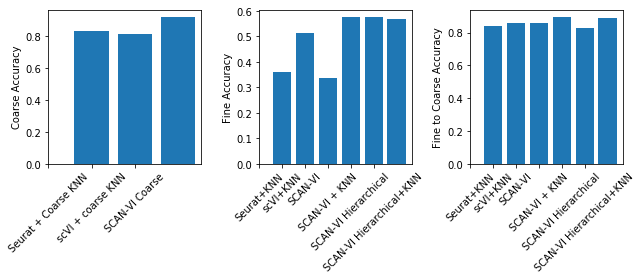

In [169]:
plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.bar([1, 2, 3], height=[seurat_coarse_acc[0],scVI_coarse_acc[0],scanvi_coarse_acc[0]])
plt.xticks([0,1, 2], ["Seurat + Coarse KNN","scVI + coarse KNN","SCAN-VI Coarse"],rotation=45)
plt.ylabel("Coarse Accuracy")
plt.subplot(132)
plt.bar([1,2,3,4,5,6], height=[seurat_fine_acc[0],scVI_fine_acc[0],scanvi_fine_acc[0],fine_acc[0],scanvi_hier_acc[0],hier_acc[0]])
plt.xticks([0,1,2,3,4,5], ['Seurat+KNN','scVI+KNN',"SCAN-VI","SCAN-VI + KNN" ,"SCAN-VI Hierarchical","SCAN-VI Hierarchical+KNN"],rotation=45)
plt.ylabel("Fine Accuracy")
plt.tight_layout()
plt.subplot(133)
plt.bar([1,2,3,4,5,6], height=[seurat_fine_coarse_acc[0],scVI_fine_coarse_acc[0],scanvi_fine_coarse_acc[0],fine_coarse_acc[0],scanvi_hier_coarse_acc[0],hier_coarse_acc[0]])
plt.xticks([0,1,2,3,4,5], ['Seurat+KNN','scVI+KNN',"SCAN-VI","SCAN-VI + KNN" ,"SCAN-VI Hierarchical","SCAN-VI Hierarchical+KNN"],rotation=45)
plt.ylabel("Fine to Coarse Accuracy")
plt.tight_layout()
plt.savefig("figures/hierarch_accuracy.pdf", transparency=True)

In [150]:
import matplotlib 
%matplotlib inline  

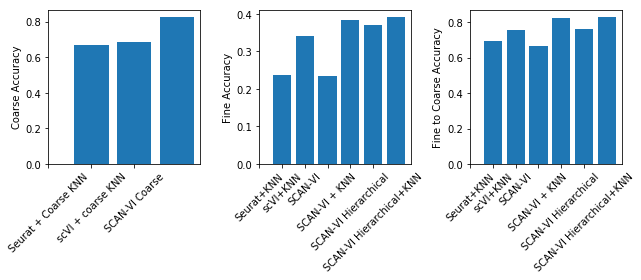

In [170]:
plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.bar([1, 2, 3], height=[seurat_coarse_acc[1],scVI_coarse_acc[1],scanvi_coarse_acc[1]])
plt.xticks([0,1, 2], ["Seurat + Coarse KNN","scVI + coarse KNN","SCAN-VI Coarse"],rotation=45)
plt.ylabel("Coarse Accuracy")
plt.subplot(132)
plt.bar([1,2,3,4,5,6], height=[seurat_fine_acc[1],scVI_fine_acc[1],scanvi_fine_acc[1],fine_acc[1],scanvi_hier_acc[1],hier_acc[1]])
plt.xticks([0,1,2,3,4,5], ['Seurat+KNN','scVI+KNN',"SCAN-VI","SCAN-VI + KNN" ,"SCAN-VI Hierarchical","SCAN-VI Hierarchical+KNN"],rotation=45)
plt.ylabel("Fine Accuracy")
plt.tight_layout()
plt.subplot(133)
plt.bar([1,2,3,4,5,6], height=[seurat_fine_coarse_acc[1],scVI_fine_coarse_acc[1],scanvi_fine_coarse_acc[1],fine_coarse_acc[1],scanvi_hier_coarse_acc[1],hier_coarse_acc[1]])
plt.xticks([0,1,2,3,4,5], ['Seurat+KNN','scVI+KNN',"SCAN-VI","SCAN-VI + KNN" ,"SCAN-VI Hierarchical","SCAN-VI Hierarchical+KNN"],rotation=45)
plt.ylabel("Fine to Coarse Accuracy")
plt.tight_layout()
plt.savefig("figures/hierarch_accuracy.weighted.pdf", transparency=True)